X Chromosomes Performance Results

In [44]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix as cm
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt 

In [45]:
cur_dirname = os.getcwd()

ecole_predictions_path = "./ecole_predictions_1000genomes_test/"

test_set = os.listdir(ecole_predictions_path)
samples = [sample.split(".")[0] for sample in test_set]

sample_info = pd.read_csv('igsr_samples.tsv', sep='\t')
filter = sample_info["Sample name"].isin(samples)
sample_info = sample_info[filter]
sampleSex = sample_info.set_index("Sample name").to_dict()["Sex"]


[75, 82]


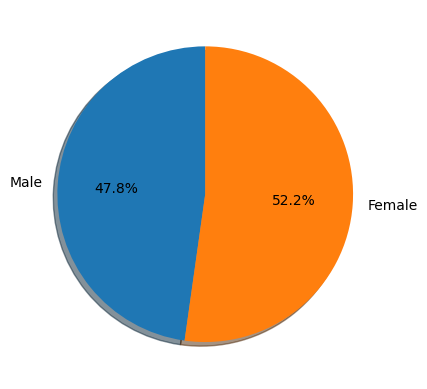

In [55]:
labels = ["Male","Female"]
sizes = [sum(sample_info["Sex"]=="male"),sum(sample_info["Sex"]=="female")]
print(sizes)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()


In [59]:
preds_ = {"female" : np.array([]), "male" : np.array([])}
wgs_preds_ = {"female" : np.array([]), "male" : np.array([])}

for sample_name in tqdm(samples):
    ecole_calls_data = pd.read_csv(ecole_predictions_path + sample_name + ".csv", sep=",",header=None)
    ecole_calls_data = ecole_calls_data[ecole_calls_data[0]=="chrX"]
    wgs_calls_data = pd.read_csv(os.path.join(cur_dirname,f"../../../Groundtruths_exon_matched/1000genomes_exon_matched_truths/Groundtruth_") + sample_name + ".csv", sep=",",header=None)
    wgs_calls_data = wgs_calls_data[wgs_calls_data[0]=="chrX"]
    new_df = pd.merge(wgs_calls_data, ecole_calls_data,  how='left', left_on=[0,1,2], right_on = [0,1,2]).values

    gender = sampleSex[sample_name]
    wgs_preds_n = np.array(new_df[:,3]) 
    wgs_preds_[gender] = np.append(wgs_preds_[gender],wgs_preds_n)
    preds_n= np.array(new_df[:,4]) 
    preds_[gender] = np.append(preds_[gender],preds_n)

100%|██████████| 157/157 [00:17<00:00,  9.19it/s]


In [60]:
delrecall_ = {"male":0,"female" :0}
duprecall_ = {"male":0,"female" :0}
delprec_ = {"male":0,"female" :0}
dupprec_ = {"male":0,"female" :0}


for gender in ["male","female"]:
    wgs_preds_[gender][wgs_preds_[gender] == "<DEL>"] = 2
    wgs_preds_[gender][wgs_preds_[gender]== "<DUP>"] = 1
    wgs_preds_[gender][wgs_preds_[gender] == "<NO-CALL>"] = 0
    wgs_preds_[gender] = wgs_preds_[gender].astype(int)
    
    delcalls = wgs_preds_[gender] == 2
    dupcalls = wgs_preds_[gender] == 1
    nocallcalls = wgs_preds_[gender] == 0


    preds_[gender] = preds_[gender].astype(int)

    delpreds_ = preds_[gender] == 2
    duppreds_  = preds_[gender] == 1
    nocallpreds_  = preds_[gender] == 0

    delrecall_[gender]  = np.sum(delpreds_ * delcalls) / np.sum(delcalls)
    duprecall_[gender]  = np.sum(duppreds_ * dupcalls) / np.sum(dupcalls)


    delprec_[gender]  = np.sum(delpreds_  * delcalls) / np.sum(delpreds_)
    dupprec_[gender]  = np.sum(duppreds_  * dupcalls) / np.sum(duppreds_)


[0.9166666666666666, 0.004252029377657518, 0.2522326966013396, 0.4286015386236695]
[0.5, 0.005504587155963303, 0.8416828120675339, 0.728732326863168]


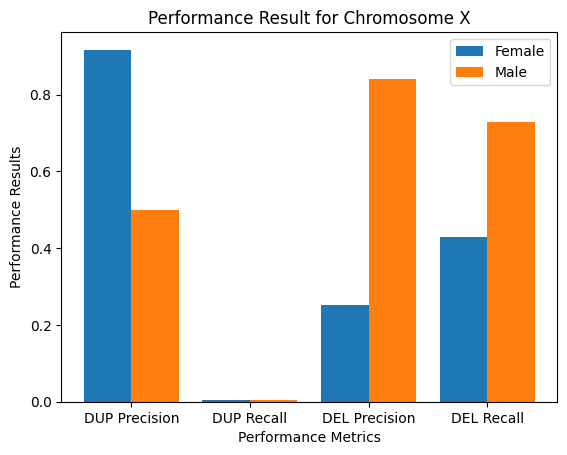

In [62]:
X = ['DUP Precision','DUP Recall', 'DEL Precision','DEL Recall',]
FemaleResult = [delprec_["female"], delrecall_["female"], dupprec_["female"], duprecall_["female"]]
MaleResult = [delprec_["male"], delrecall_["male"], dupprec_["male"], duprecall_["male"]]

print(FemaleResult)
print(MaleResult)

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, FemaleResult, 0.4, label = 'Female')
plt.bar(X_axis + 0.2, MaleResult, 0.4, label = 'Male')
  
plt.xticks(X_axis, X)
plt.xlabel("Performance Metrics")
plt.ylabel("Performance Results")
plt.title("Performance Result for Chromosome X")
plt.legend()
plt.show()